## Lightning Data Analysis & Exploration
The purpose of this notebook is to analyze lightning data and corresponding datasets of Radar Reflectivities, Weather Variables etc. 

In [1]:
import xarray as xr
from azure.storage.blob import BlobServiceClient
import zarr
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# get credential from .env
load_dotenv()
storage_account_name = os.getenv('AZURE_STORAGE_ACCOUNT_NAME')
sas_token = os.getenv('AZURE_STORAGE_SAS_TOKEN')
container_name = os.getenv('CONTAINER_NAME')
azure_url=os.getenv('AZURE_URL')

In [2]:
# Boiler plate code for reading data from a remote storage blob
def read_zarr_from_blob(account_name, container_name, blob_name):
    sas_token = os.getenv('AZURE_STORAGE_SAS_TOKEN')
    blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net", credential=sas_token)
    container_client = blob_service_client.get_container_client(container_name)
    zarr_store = zarr.ABSStore(prefix=blob_name, client=container_client)
    ds = xr.open_zarr(zarr_store)
    return ds

In [3]:
# Load lightning data from zarr store
account_name = os.getenv('AZURE_STORAGE_ACCOUNT_NAME')
container_name = os.getenv('AZURE_STORAGE_ACCOUNT_NAME')
blob_name_lightning = "data/lightning.zarr"
ds = read_zarr_from_blob(account_name, container_name, blob_name_lightning);
# print(ds)

In [4]:
# Load lightning data for CONUS region for 2018
ds_conus = ds.sel(
    latitude=slice(50, 25),
    longitude=slice(235, 295),
    time=slice('2022-01-01', '2022-12-31')
)

# Get Mean lightning data for CONUS region for 2018
mean_lightning = ds_conus.lightning.mean(dim='time').compute()

We will now plot average lightning data for 2018 and then find area where lightning activity is highest

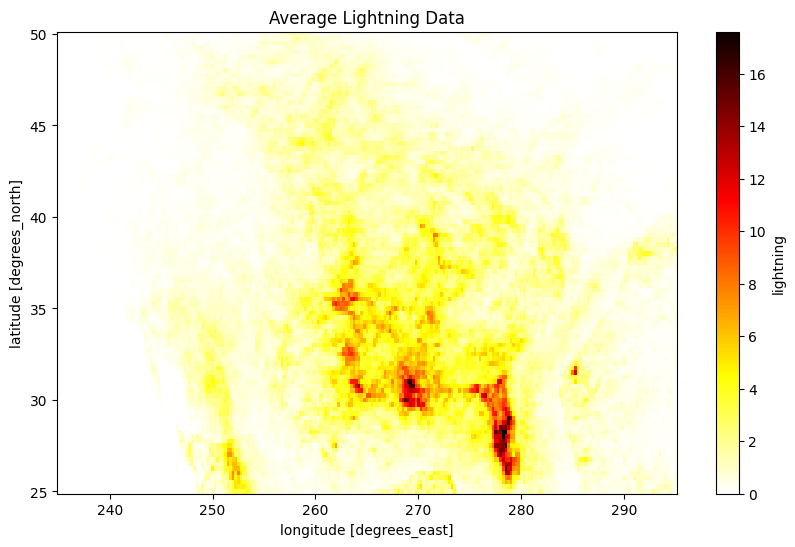

In [5]:
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create a map projection
#projection = ccrs.PlateCarree()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6)) #subplot_kw={'projection': projection})

# Plot the average lightning data on the map
mean_lightning.plot(ax=ax, cmap='hot_r') #  transform=ccrs.PlateCarree(), cmap='hot_r')

# Add map features
# ax.coastlines()
#ax.gridlines()

# Set the title
ax.set_title('Average Lightning Data')

# Show the plot
plt.show()

In [6]:
# Find the maximum lightning activity
max_lightning = mean_lightning.max()

# Find the latitude and longitude of the maximum lightning activity
lat = mean_lightning.where(mean_lightning == max_lightning, drop=True).latitude.values[0]
lon = mean_lightning.where(mean_lightning == max_lightning, drop=True).longitude.values[0]

# Lets get the region with maximum lightning activity
lat_region = [lat - 0.5, lat + 0.5]
lon_region = [lon - 0.5, lon + 0.5]

# Report the region with maximum lightning activity and the radius of the 5x5 grid
print(f"Region with maximum lightning activity: Latitude {lat}, Longitude {lon}")


Region with maximum lightning activity: Latitude 26.75, Longitude 278.25


In [7]:
# Lets plot an annual time-series of lightning activity for the region with maximum lightning activity
ds_max_lightning = ds.sel(
    latitude=slice(lat_region[1], lat_region[0]),
    longitude=slice(lon_region[0], lon_region[1]),
    time=slice('2018-01-01', '2018-12-31')
).compute()

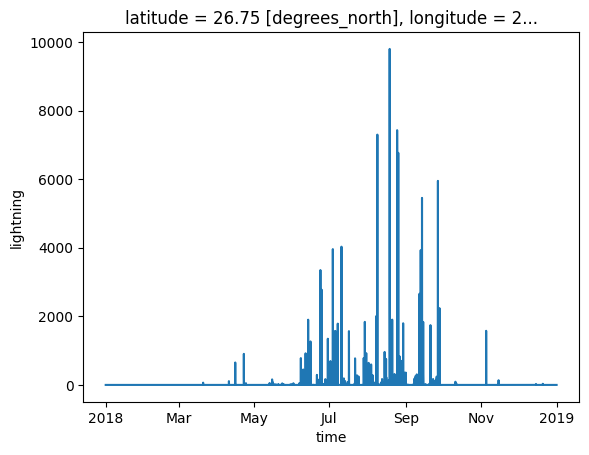

In [8]:
# Plot the time-series of lightning activity for the maximum activity pixel
ds_max_lightning.sel(latitude=lat, longitude=lon, time=slice('2018-01-01', '2018-12-31')).lightning.plot()


In the following code, we attempt to extract reflectivities for region and date of a lightning activity, interpolate to lightning grid and plot the same

In [9]:
# only have 202207-202208 and 201807-201808 radar data
ds_test = read_zarr_from_blob(account_name, container_name, "data/SHSR/20220701.zarr")
print(ds_test)

<xarray.Dataset> Size: 16GB
Dimensions:    (time: 720, latitude: 1628, longitude: 3428)
Coordinates:
  * latitude   (latitude) float64 13kB 52.56 52.54 52.52 ... 20.06 20.04 20.02
  * longitude  (longitude) float64 27kB 231.4 231.5 231.5 ... 299.9 300.0 300.0
  * time       (time) datetime64[ns] 6kB 2022-07-01 ... 2022-07-01T23:58:00
Data variables:
    SHSR       (time, latitude, longitude) float32 16GB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2023-08-10T07:20 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             161


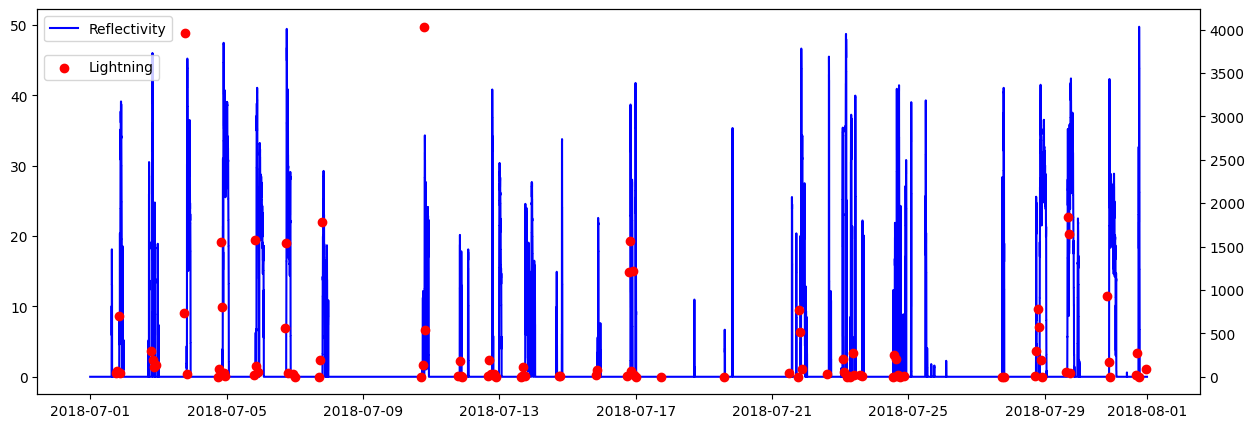

In [20]:
start_time = pd.to_datetime('2018-07-01 00:00:00')
end_time = pd.to_datetime('2018-07-31 23:59:59')

refliectivites = []

for activity_date in pd.date_range(start_time, end_time, freq='D'):
    # Load Radar Reflectivity data from zarr store for the same region and time period
    radar_date = activity_date.strftime('%Y%m%d')
    blob_name_reflectivity = f"data/SHSR/{radar_date}.zarr"
    ds_reflectivity = read_zarr_from_blob(account_name, container_name, blob_name_reflectivity)

    # Restrict reflectivity data to the same region as the lightning data
    ds_reflectivity_max_lightning = ds_reflectivity.sel(
        latitude=slice(lat_region[1], lat_region[0]),
        longitude=slice(lon_region[0], lon_region[1]),
        time=slice(activity_date, activity_date + pd.Timedelta('1D'))
    ).compute()

    # User xarray interp function to upsample the reflectivity data to the same spatial resolution as the lightning data
    ds_reflectivity_max_lightning_interp = ds_reflectivity_max_lightning.interp(
        latitude=ds_max_lightning.latitude,
        longitude=ds_max_lightning.longitude,
        method='linear',
        kwargs={"fill_value": "extrapolate"}
    )
    refliectivites.append(ds_reflectivity_max_lightning_interp)

ds_reflectivity_max_lightning_interp = xr.concat(refliectivites, dim='time')

# Plot reflectivity time-series and lightning time-series together on the same plot for lat and lon
fig, ax = plt.subplots(figsize=(15, 5))
my_data = ds_reflectivity_max_lightning_interp.sel(latitude=lat, longitude=lon)
ax.step(my_data.time, my_data.SHSR, color='blue')
ax_2 = ax.twinx()
# make some changes
# my_data = ds_max_lightning.sel(latitude=lat, longitude=lon, time=slice(activity_date, activity_date + pd.Timedelta('1D')))
my_data = ds_max_lightning.sel(latitude=lat, longitude=lon, time=slice(start_time, end_time))
my_data_filtered = my_data.where(my_data.lightning > 0, drop=True)
ax_2.scatter(my_data_filtered.time, my_data_filtered.lightning, color='red')

# Add legend
ax.legend(['Reflectivity'], loc='upper left')
ax_2.legend(['Lightning'], loc='upper left', bbox_to_anchor=(0.0, 0.9))

# Set labels
ax.set_label('Reflectivity')
ax_2.set_label('Lightning')

plt.show()

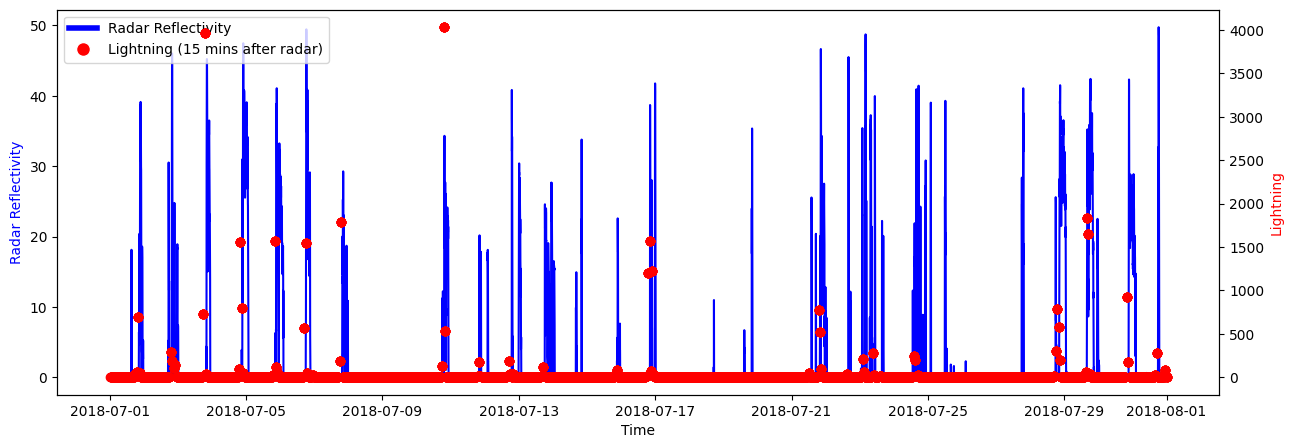

In [69]:
# analyze the relationship between radar reflectivity and lightning activity(15 minutes)
# after 1, 2, 4, 12 hrs
# Visualize the radar reflectivity data
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(ds_reflectivity_max_lightning_interp.time, ds_reflectivity_max_lightning_interp.sel(latitude=lat, longitude=lon).SHSR, color='blue', label='Radar Reflectivity')
ax1.set_xlabel('Time')
ax1.set_ylabel('Radar Reflectivity', color='blue')

# set the second y-axis to plot the lightning data
ax2 = ax1.twinx()

# for each time point in the radar data, find the lightning data 15 minutes later and plot it
for radar_time in ds_reflectivity_max_lightning_interp.time.values:
    # time point of the radar data
    radar_time = pd.to_datetime(radar_time)
    
    # time point 15 minutes later
    time_plus_15m = radar_time + pd.Timedelta(minutes=15)
    
    # use where and condition to select lightning data within the time range
    condition = (ds_max_lightning.time >= radar_time) & (ds_max_lightning.time <= time_plus_15m)
    lightning_data_in_range = ds_max_lightning.where(condition, drop=True)
    
    # if there is lightning data in this 15 minutes, plot it
    if not lightning_data_in_range.time.size == 0:
        ax2.scatter(lightning_data_in_range.time, lightning_data_in_range.sel(latitude=lat, longitude=lon).lightning, color='red', label='Lightning (15 mins after radar)')

ax2.set_ylabel('Lightning', color='red')

# since the label of scatter plot will be repeated multiple times, we can manually add legend
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Radar Reflectivity'),
                   Line2D([0], [0], marker='o', color='w', label='Lightning (15 mins after radar)',
                          markerfacecolor='red', markersize=10)]
ax1.legend(handles=legend_elements, loc='upper left')

plt.show()